In [ ]:
!pip install -q pyomo

In [ ]:
!apt-get install -y -qq glpk-utils

In [ ]:
#final
import pandas as pd
from pyomo.environ import *

# Read data from Excel file
data = pd.read_excel('/content/test_data.xlsx')

# Загрузка данных из Excel в DataFrame
df = pd.read_excel('/content/book_test.xlsx', index_col=0, header=0)


# Create model
model = ConcreteModel()

# Sets
model.Days = range(1, 10) # Set of days
model.Operations = Set(initialize=data['Operation ID'])
model.OperatingRooms = Set(initialize=data['Operating Room'].unique())
model.Departments = Set(initialize=data['Department'].unique())

# Parameters
model.OperationTime = Param(model.Operations, initialize=dict(zip(data['Operation ID'], data['Operation Time'])))
#model.Anesthesia = Param(model.Operations, initialize=dict(zip(data['Operation ID'], data['Anesthesia'])))
model.OperatingRoomDepartment = Param(model.OperatingRooms, model.Departments, mutable=True, default=0)
model.Weight = Param(model.Operations, model.OperatingRooms, mutable=True, initialize=lambda m, i, j: df.loc[(i, j)])

# Assign operating rooms to departments
for i, j in zip(data['Operating Room'], data['Department']):
    model.OperatingRoomDepartment[i, j] = 1


# Other parameters and variables...
model.OperatingRoomTime = Param(model.OperatingRooms, initialize={i: 720 for i in model.OperatingRooms})
model.HasXRay = Param(model.OperatingRooms, initialize=dict(zip(data['Operating Room'], data['Has X-Ray'])))  # X-Ray requirement for each operation
model.NeedXRay = Param(model.Operations, initialize=dict(zip(data['Operation ID'], data['Need X-Ray'])))  # X-Ray availability in each operating room   # X-Ray availability in each operating room
model.WaitPenalty = Param(initialize = 400)  # Penalty for waiting operations


# Variables
model.x = Var(model.Operations, model.OperatingRooms, model.Days, domain=Binary)
model.wait = Var(model.Operations, domain=Binary)
# Objective Function
def obj_rule(model):
    return sum(model.OperationTime[i] * model.Weight[i, j] * model.x[i, j, k] for i in model.Operations for j in model.OperatingRooms for k in model.Days) + sum(model.WaitPenalty * model.wait[i] for i in model.Operations)
model.obj = Objective(rule=obj_rule, sense=minimize)

# Constraints
def one_operation_per_room_per_day_rule(model, i, k):
    return sum(model.x[i, j, k] for j in model.OperatingRooms) <= 1
model.OneOperationPerRoomPerDay = Constraint(model.Operations, model.Days, rule=one_operation_per_room_per_day_rule)

def operation_time_rule(model, j, k):
    return sum(model.OperationTime[i] * model.x[i, j, k] for i in model.Operations) <= model.OperatingRoomTime[j]
model.OperationTimeConstraint = Constraint(model.OperatingRooms, model.Days, rule=operation_time_rule)

def operation_once_rule(model, i):
    return sum(model.x[i, j, k] for j in model.OperatingRooms for k in model.Days) + model.wait[i] == 1
model.OperationOnce = Constraint(model.Operations, rule=operation_once_rule)

def xray_constraint_rule(model, i, j, k):
    return model.NeedXRay[i] * model.x[i, j, k] <= model.HasXRay[j]
model.XRayConstraint = Constraint(model.Operations, model.OperatingRooms, model.Days, rule=xray_constraint_rule)

# Solve the problem
SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model).write()

# Display solution
print('\nProfit = ', model.obj())
#model.x.display()
#model.wait.display()
print("\nValues of x where x = 1:")
cnt = 0
for i in model.Operations:
    for j in model.OperatingRooms:
        for k in model.Days:
            if value(model.x[i, j, k]) == 1:
                print(f"Operation: {i}, Operating Room: {j}, Day: {k}")
                cnt = cnt + 1
print(cnt)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 52929.6
  Upper bound: 52929.6
  Number of objectives: 1
  Number of constraints: 133474
  Number of variables: 130334
  Number of nonzeros: 426253
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 607
      Number of created subproblems: 607
  Error rc: 0
  Time: 162.10326886177063
# ----------------------------------------------------------
#   Solution Information
# ---------------

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


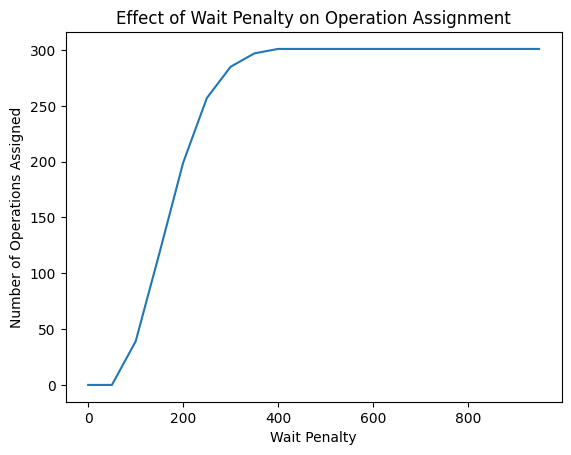

In [ ]:
import matplotlib.pyplot as plt

# Create a list to store the results
wait_penalties = list(range(0, 1000, 50))  # Range of wait penalties from 0 to 1000
num_operations_assigned = []
model.WaitPenalty = Param(mutable=True, initialize=200)  # Declare WaitPenalty as mutable
# Solve the model for each wait penalty value
for wait_penalty in wait_penalties:
    def obj_rule(model):
      return sum(model.OperationTime[i] * model.Weight[i, j] * model.x[i, j, k] for i in model.Operations for j in model.OperatingRooms for k in model.Days) + sum(model.WaitPenalty * model.wait[i] for i in model.Operations)
    model.obj = Objective(rule=obj_rule, sense=minimize)

    model.WaitPenalty = wait_penalty  # Update the wait penalty parameter
    SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model)
    num_assigned = sum(1 for i in model.Operations for j in model.OperatingRooms for k in model.Days if model.x[i, j, k].value == 1)
    num_operations_assigned.append(num_assigned)

# Plot the results
plt.plot(wait_penalties, num_operations_assigned)
plt.xlabel('Wait Penalty')
plt.ylabel('Number of Operations Assigned')
plt.title('Effect of Wait Penalty on Operation Assignment')
plt.show()